In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seisbench.data as sbd
import seisbench.generate as sbg
import torch
import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

from seisLM.model.foundation.pretrained_models import (
  LitMultiDimWav2Vec2,
  MultiDimWav2Vec2ForPreTraining,
)
from seisLM.utils import project_path

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

Dataloader

1. only extract 1000 samples for each class (earthquake vs noise)
2. return meta data for each sample

In [2]:
class MetaDataKeepingSteeredGenerator(sbg.SteeredGenerator):
  def _clean_state_dict(self, state_dict):
    # Remove control information
    trace_type = state_dict["_control_"]["trace_type"]

    X, meta = state_dict["X"]
    path_ep_distance_km = meta.get("path_ep_distance_km", np.inf)
    path_hyp_distance_km = meta.get("path_hyp_distance_km", np.inf)

    state_dict = {
      "X": X,
      "trace_type": trace_type,
      "path_ep_distance_km": path_ep_distance_km,
      "path_hyp_distance_km": path_hyp_distance_km,
    }
    return state_dict


def get_loader():
  dataset_name = "InstanceCountsCombined"
  task = "1"
  num_samples_per_trace_type = 1000

  dataset = sbd.__getattribute__(dataset_name)(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    missing_component="copy",
    cache=None,
  )
  metadata_df = dataset.metadata

  eval_set = "dev"
  split = dataset.get_split(eval_set)

  # task_csv = f'/home/liu0003/Desktop/projects/seisLM/data/targets/{dataset_name}/task{task}.csv'
  task_csv = (
    project_path.gitdir() + f"/data/targets/{dataset_name}/task{task}.csv"
  )

  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]

  eq_targets = task_targets[task_targets["trace_type"] == "earthquake"].head(
    num_samples_per_trace_type
  )
  noise_targets = task_targets[task_targets["trace_type"] == "noise"].head(
    num_samples_per_trace_type
  )

  task_targets = pd.concat([eq_targets, noise_targets])

  generator = MetaDataKeepingSteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
      sbg.SteeredWindow(windowlen=3001, strategy="pad"),
      sbg.ChangeDtype(np.float32),
      sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    ]
  )
  batch_size = 10
  num_workers = 2
  loader = DataLoader(
    generator,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
  )
  return loader


loader = get_loader()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_collections = {}

for model_type in ["pretrained", "random_init"]:
  model = LitMultiDimWav2Vec2.load_from_checkpoint(
    # '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
    project_path.gitdir()
    +
    # '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
    "/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_sample_pick_false_42__2024-08-31-18h-41m-44s/checkpoints/epoch=35-step=1082700.ckpt",
    # "/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_32bit_scaleup_samp_false_42__2024-09-01-23h-26m-07s/checkpoints/epoch=36-step=649091.ckpt"
  ).model

  if model_type == "random_init":
    model = MultiDimWav2Vec2ForPreTraining(model.config)

  model = model.to(device)
  model = model.eval()
  model_collections[model_type] = model
  del model

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5
/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.5


In [4]:
embeddings_of_models = {}

for model_type, model in model_collections.items():
  batch_input_dict = defaultdict(list)
  batch_features_dict = defaultdict(list)

  for batch in tqdm.tqdm(loader):
    for key, value in batch.items():
      batch_input_dict[key].append(value)

    with torch.no_grad():
      input_values = batch["X"]
      wav2vec2_output = model.wav2vec2(
        input_values=input_values.cuda(),
        output_hidden_states=True,
      )

    batch_features_dict["conv_features"].append(
      wav2vec2_output.extract_features.mean(axis=1)
    )

    for hidden_states_layer_idx, hidden_states in enumerate(
      wav2vec2_output.hidden_states
    ):
      batch_features_dict[f"hidden_states_{hidden_states_layer_idx}"].append(
        hidden_states.mean(axis=1)
      )

  all_features_dict = defaultdict(list)
  all_input_values = defaultdict(list)

  for key, value in batch_features_dict.items():
    concat_features = torch.concatenate(value, axis=0).cpu().numpy()
    all_features_dict[key] = concat_features

  for key, value in batch_input_dict.items():
    if isinstance(value[0], torch.Tensor):
      concat_values = torch.cat(value, axis=0).cpu().numpy()
    elif isinstance(value[0], np.ndarray) or isinstance(value[0], list):
      concat_values = np.concatenate(value, axis=0)
    else:
      raise ValueError
    all_input_values[key] = concat_values

  embedding_dict = defaultdict(list)

  for key, value in tqdm.tqdm(all_features_dict.items()):
    # pca = PCA(n_components=2)
    # embedding_dict[key] = pca.fit_transform(value)

    tsne = TSNE(
      n_components=2,
      max_iter=500,
      n_iter_without_progress=150,
      n_jobs=2,
      random_state=0,
    )

    embedding = tsne.fit_transform(value)
    embedding_dict[key] = embedding

  embeddings_of_models[model_type] = embedding_dict

  0%|          | 0/200 [00:00<?, ?it/s]2024-09-09 15:16:27,032 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-09 15:16:27,057 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
  0%|          | 0/200 [00:00<?, ?it/s]2024-09-09 15:17:15,882 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-09-09 15:17:15,921 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
100%|██████████| 8/8 [00:39<00:00,  4.99s/it]


In [5]:
all_trace_types = all_input_values["trace_type"]

position key, hidden_states_6


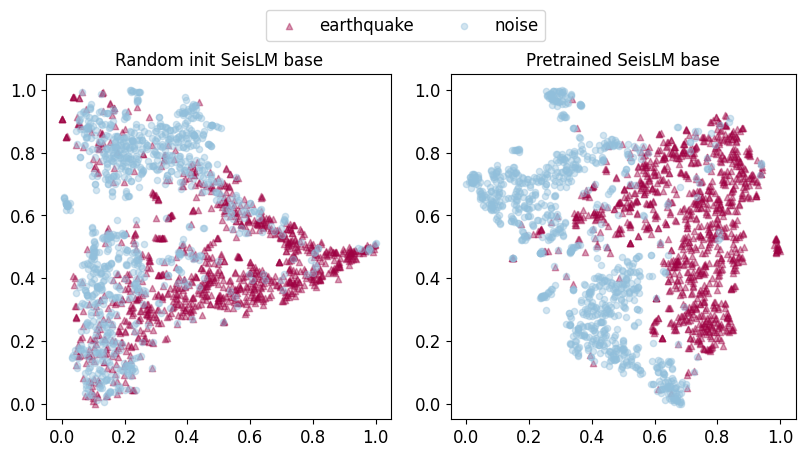

: 

In [18]:
import numpy as np

# Configuration and constants
markers = {"noise": "o", "earthquake": "^"}
a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 2
marker_size = 20
show_all_trace_indices = False
trace_indices = [1600, 1400, 600, 0]

# Create figure with two subplots side by side
fig, (ax_col1, ax_col2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))

FONT_SIZE = 12
# Create figure with two subplots side by side
plt.rcParams.update(
  {
    "font.size": FONT_SIZE,  # General font size
    "axes.titlesize": FONT_SIZE,  # Subplot titles
    "figure.titlesize": FONT_SIZE,  # Suptitle (main title)
    "legend.fontsize": FONT_SIZE,  # Legend font size
    "pdf.fonttype": 42,  # Embed fonts in PDF for better compatibility
  }
)


def plot_embeddings(ax, embeddings, trace_type, label, color, marker):
  embedding_of_label = embeddings[np.array(label) == trace_type]
  ax.scatter(
    *embedding_of_label.T,
    label=label,
    marker=marker,
    s=marker_size,
    c=color,
    alpha=0.4,
    zorder=2,
  )

  if show_all_trace_indices:
    label_indices = np.where(np.array(label) == trace_type)[0]
    embedding_of_label = embeddings[label_indices]
    dot_indices = np.arange(len(embedding_of_label))[::200]
    for dot_index in dot_indices:
      x, y = embedding_of_label[dot_index]
      ax.text(x, y, str(label_indices[dot_index]), fontsize=8, ha="right")


def annotate_traces(ax, embeddings, trace_indices):
  for trace_index in trace_indices:
    x, y = embeddings[trace_index]
    ax.text(
      x,
      y,
      str(trace_index),
      fontsize=12,
      ha="right",
      bbox=dict(facecolor="#e0e0e0", edgecolor="none", pad=1),
    )


# Plot for random_init in the first subplot

position_key = list(embeddings_of_models["random_init"])[-1]
print(f"position key, {position_key}")
embeddings_random = MinMaxScaler().fit_transform(
  embeddings_of_models["random_init"][position_key]
)
# embeddings_random = embeddings_of_models['random_init']['hidden_states_6']
for label, color in zip(["earthquake", "noise"], ["#9e0142", "#91bfdb"]):
  plot_embeddings(
    ax_col1, embeddings_random, all_trace_types, label, color, markers[label]
  )
# annotate_traces(ax_col1, embeddings_random, trace_indices)
# ax_col1.legend()
ax_col1.set_aspect("equal")  # Ensure the scatter plot is square
ax_col1.set_title("Random init SeisLM base")

# Plot for pretrained in the second subplot
embeddings_pretrained = MinMaxScaler().fit_transform(
  embeddings_of_models["pretrained"][position_key]
)
# embeddings_pretrained = embeddings_of_models['pretrained']['hidden_states_6']
for label, color in zip(["earthquake", "noise"], ["#9e0142", "#91bfdb"]):
  plot_embeddings(
    ax_col2,
    embeddings_pretrained,
    all_trace_types,
    label,
    color,
    markers[label],
  )
# annotate_traces(ax_col2, embeddings_pretrained, trace_indices)
# ax_col2.legend()
ax_col2.set_aspect("equal")  # Ensure the scatter plot is square
ax_col2.set_title("Pretrained SeisLM base")

# Adjust layout for better spacing
plt.tight_layout()

# plt.subplots_adjust(wspace=0.3)  # Adjust wspace to control the space between plots
handles, labels = ax_col1.get_legend_handles_labels()
fig.legend(
  handles,
  labels,
  loc="upper center",
  ncol=len(labels),
  bbox_to_anchor=(0.5, 1.1),
  frameon=True,
)

plt.show()

# fig.savefig( project_path.FIGURE_DIR + f'/trace_embedding.pdf')
fig.savefig(
  project_path.FIGURE_DIR + "/trace_embedding.pdf", bbox_inches="tight"
)


In [14]:
handles

In [ ]:
embeddings_of_models["pretrained"].keys()

dict_keys(['conv_features', 'hidden_states_0', 'hidden_states_1', 'hidden_states_2', 'hidden_states_3', 'hidden_states_4', 'hidden_states_5', 'hidden_states_6', 'hidden_states_7', 'hidden_states_8', 'hidden_states_9', 'hidden_states_10', 'hidden_states_11', 'hidden_states_12'])